Code Author: Oscar LI

This Strategy based on Testing the Applicability of the Technical Trading Strategy in the Cryptocurrency Market. Journal of Finance and Economics, 11(4), 195-234. doi: 10.12691/jfe-11-4-2, by Chen, A., Wang, Z., & Yang, M. (2023)

Link to reference: https://pubs.sciepub.com/jfe/11/4/2/

The idea is to using Technical Trading Strategies on cryptocurrency market, mainly BTC/USDT and ETH/USDT pair. EMAC Strategy, RSI Strategy, Bollinger Bands Strategy and MACD Strategy are suggested to formulate a profitable strategy.

The performance of the strategies are evaulated by 2 approaches, the annualized return and the sharpe ratio. 
Also, the performance will be assessed on its profitability over the whole sample and the profitability in In-sample period and Out-of-Sample periods.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

The research paper suggested to use the daily price data of Bitcoin(BTC) and Ethereum(ETH) from 2017-11-09 to 2023-10-31, around 6 years data from yahoo finance.

In [2]:
import os
from datetime import datetime
import yfinance as yf

# Set the start and end date
start_date = datetime(2017, 1, 1)
end_date = datetime.now()

# Create data directory if it does not exist
data_dir = '../data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Fetch BTC data
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(start=start_date, end=end_date)
btc_data.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)

# Fetch ETH data
eth = yf.Ticker("ETH-USD")
eth_data = eth.history(start=start_date, end=end_date)
eth_data.rename(columns={'Date': 'date', 'Close': 'close'}, inplace=True)

# Save data to CSV files
btc_data.to_csv(os.path.join(data_dir, 'yfinance_BTC.csv'))
eth_data.to_csv(os.path.join(data_dir, 'yfinance_ETH.csv'))

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [3]:
in_sample_start_date = '2017-11-09'
in_sample_end_date = '2021-12-20'
out_of_sample_start_date = '2021-12-20'
out_of_sample_end_date = '2023-10-31'

In [4]:
btc_df = pd.read_csv('../data/yfinance_BTC.csv')
btc_df = btc_df.set_index('Date')
btc_df.index = pd.to_datetime(btc_df.index)
btc_df['ROC'] = (btc_df['close'] - btc_df['Open']) / btc_df['Open']
btc_df_in_sample = btc_df.loc[in_sample_start_date:in_sample_end_date]
btc_df_out_of_sample = btc_df.loc[out_of_sample_start_date:out_of_sample_end_date]
btc_df_full = btc_df.loc[in_sample_start_date:out_of_sample_end_date]
eth_df = pd.read_csv('../data/yfinance_ETH.csv')
eth_df = eth_df.set_index('Date')
eth_df.index = pd.to_datetime(eth_df.index)
eth_df['ROC'] = (eth_df['close'] - eth_df['Open']) / eth_df['Open']
eth_df_in_sample = eth_df.loc[in_sample_start_date:in_sample_end_date]
eth_df_out_of_sample = eth_df.loc[out_of_sample_start_date:out_of_sample_end_date]
eth_df_full = eth_df.loc[in_sample_start_date:out_of_sample_end_date]
btc_df_full, eth_df_full

(                                   Open          High           Low  \
 Date                                                                  
 2017-11-09 00:00:00+00:00   7446.830078   7446.830078   7101.520020   
 2017-11-10 00:00:00+00:00   7173.729980   7312.000000   6436.870117   
 2017-11-11 00:00:00+00:00   6618.609863   6873.149902   6204.220215   
 2017-11-12 00:00:00+00:00   6295.450195   6625.049805   5519.009766   
 2017-11-13 00:00:00+00:00   5938.250000   6811.189941   5844.290039   
 ...                                 ...           ...           ...   
 2023-10-27 00:00:00+00:00  34156.500000  34238.210938  33416.886719   
 2023-10-28 00:00:00+00:00  33907.722656  34399.390625  33874.804688   
 2023-10-29 00:00:00+00:00  34089.371094  34743.261719  33947.566406   
 2023-10-30 00:00:00+00:00  34531.742188  34843.933594  34110.972656   
 2023-10-31 00:00:00+00:00  34500.078125  34719.253906  34083.308594   
 
                                   close       Volume  Dividen

Simulation function to calculate returns

In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

commission = 4/10000 ## 3 bps from cost, 1 bps from slippage

def simulation(performance_df,Type):

    performance_df['close'] = performance_df['close'].astype(float)
    ## return is calculated by log_return
    # performance_df['ROC'] = (performance_df['close'] - performance_df['Open']) / performance_df['Open']
    performance_df['pos'] = performance_df['signal'].shift(1)  # position when signal was received (meaning, position is updated on the next row)
    performance_df['trade'] = performance_df['signal'].diff().shift(1)   # while signal reflects the new position, trade reflects the transaction made during close time
    
    performance_df['return'] = ((performance_df['pos'] * performance_df['ROC']+1)*(1-(abs(performance_df['trade'])*commission)))-1
    performance_df['unrealized_pnl'] = performance_df['return'].add(1).groupby((performance_df['pos'] != performance_df['pos'].shift()).cumsum()).cumprod().subtract(1)
    performance_df.loc[performance_df['trade'] != 0, 'realized_pnl'] = performance_df['unrealized_pnl']
    performance_df['cum_return'] = performance_df['return'].cumsum()
    performance_df['cum_realized_pnl'] = performance_df['realized_pnl'].cumsum()
    performance_df['long_return'] = performance_df.loc[performance_df['pos'] > 0, 'return']
    performance_df['short_return'] = performance_df.loc[performance_df['pos'] < 0, 'return']
    performance_df['cum_long_return'] = performance_df['long_return'].cumsum()
    performance_df['cum_short_return'] = performance_df['short_return'].cumsum()

    return performance_df

Strategy 1: EMAC Strategy

In [6]:
## EMAC Strategy
def emac_strategy(price_df, short_window, long_window):
    df = price_df.copy()
    df['signal'] = 0.0
    
    df['long_signal'] = 0.0
    df['short_signal'] = 0.0
    df['short_ema'] = df['close'].ewm(span=short_window, adjust=False).mean()
    df['long_ema'] = df['close'].ewm(span=long_window, adjust=False).mean()
    df['signal'][short_window:] = np.where(df['short_ema'][short_window:] > df['long_ema'][short_window:], 1.0, 0.0)
    df['signal'][short_window:] = np.where(df['short_ema'][short_window:] < df['long_ema'][short_window:], -1.0, df['signal'][short_window:])
    result = simulation(df, 'Futures')
    return result

Strategy 2: RSI Strategy

In [7]:
import pandas_ta as ta
def RSI(price_df, overbought, oversold, length=14):
    df = price_df.copy()
    df['RSI'] = ta.rsi(df['close'], length)
    df['signal'] = 0

    ## condition for long and short
    df.loc[df['RSI'] > overbought, 'signal'] = 1
    df.loc[df['RSI'] < oversold, 'signal'] = -1

    ## condition for closing the position
    
    df.loc[(df['RSI'].shift() > 50) & (df['RSI'] <= 50), 'signal'] = 0
    df.loc[(df['RSI'].shift() < 50) & (df['RSI'] >= 50), 'signal'] = 0

    result = simulation(df, 'Futures')
    return result

Strategy 3: Bollinger Bands Strategy

In [8]:
def BBand(price_df, length, std):
    df = price_df.copy()
    df['SMA'] = df['close'].rolling(window=length).mean()
    df['BB_upper'] = df['SMA'] + std * df['close'].rolling(window=length).std()
    df['BB_lower'] = df['SMA'] - std * df['close'].rolling(window=length).std()
    df['signal'] = 0

    ## condition for long and short
    df.loc[df['close'] > df['BB_upper'], 'signal'] = 1
    df.loc[df['close'] < df['BB_lower'], 'signal'] = -1
    ## condition for closing the position when crossing SMA
    df.loc[(df['close'].shift() > df['SMA'].shift()) & (df['close'] <= df['SMA']), 'signal'] = 0
    df.loc[(df['close'].shift() < df['SMA'].shift()) & (df['close'] >= df['SMA']), 'signal'] = 0
    result = simulation(df, 'Futures')
    return result 

Strategy 4: MACD Strategy

In [9]:
def MACD(price_df, short, long, signal_prd):
    df = price_df.copy()
    df['EMA_short'] = df['close'].ewm(span=short, adjust=False).mean()
    df['EMA_long'] = df['close'].ewm(span=long, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal_line'] = df['MACD'].ewm(span=signal_prd, adjust=False).mean()

    # Generate trading signals
    df['signal'] = np.where(df['MACD'] > df['Signal_line'], 1, 0)
    df['signal'] = np.where(df['MACD'] < df['Signal_line'], -1, df['signal'])
    result = simulation(df, 'Futures')
    return result

In [10]:
import statsmodels.api as sm
def annualized_return(returns):
    """Calculate the annualized return"""
    average_return = np.mean(returns)
    return (1 + average_return) ** 365 - 1

def sharpe_ratio(returns, risk_free_rate=0.00):
    """Calculate the Sharpe ratio"""
    return (np.mean(returns) - risk_free_rate) / np.std(returns) * np.sqrt(365)

def max_drawdown(returns):
    """Calculate the maximum drawdown"""
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calculate_beta(stock_returns, market_returns):
    model = sm.OLS(stock_returns, sm.add_constant(market_returns))
    results = model.fit()
    beta = results.params.values[1]
    return beta

In [11]:
def record_performance_metrics(btc_result, key, result, benchmark_returns):
    strategy_returns = result['return']
    strategy_returns = strategy_returns.fillna(0)
    in_sample_returns = strategy_returns.loc[in_sample_start_date:in_sample_end_date]
    out_of_samplereturns = strategy_returns.loc[out_of_sample_start_date:out_of_sample_end_date]
    btc_result[f'{key}_whole_sample_return_series'] = strategy_returns
    btc_result[f'{key}_whole_sample_annualized_return'] = annualized_return(strategy_returns)
    btc_result[f'{key}_whole_sample_sharpe_ratio'] = sharpe_ratio(strategy_returns)
    btc_result[f'{key}_whole_sample_max_drawdown'] = max_drawdown(strategy_returns)
    btc_result[f'{key}_whole_sample_beta'] = calculate_beta(strategy_returns, benchmark_returns)
    btc_result[f'{key}_in_sample_annualized_return'] = annualized_return(in_sample_returns) 
    btc_result[f'{key}_in_sample_sharpe_ratio'] = sharpe_ratio(in_sample_returns)
    btc_result[f'{key}_in_sample_max_drawdown'] = max_drawdown(in_sample_returns)
    btc_result[f'{key}_out_of_sample_annualized_return'] = annualized_return(out_of_samplereturns)
    btc_result[f'{key}_out_of_sample_sharpe_ratio'] = sharpe_ratio(out_of_samplereturns)
    btc_result[f'{key}_out_of_sample_max_drawdown'] = max_drawdown(out_of_samplereturns)

In [12]:
btc_result = {}
for short_window in range(10, 34, 4):
    for long_window in range(35, 59, 4):
        key = f'EMAC_({short_window}, {long_window})'
        result = emac_strategy(btc_df_full, short_window=short_window, long_window=long_window)
        record_performance_metrics(btc_result, key, result, btc_df_full['ROC'])

for upper in range(70, 94, 4):
    for lower in range(20, 44, 4):
        key = f'RSI_({upper}, {lower})'
        result = RSI(btc_df_full, overbought=upper, oversold=lower)
        record_performance_metrics(btc_result, key, result, btc_df_full['ROC'])

for length in range(10, 34, 4):
    for std in range(1, 4):
        key = f'BBand_({length}, {std})'
        result = BBand(btc_df_full, length=length, std=std)
        record_performance_metrics(btc_result, key, result, btc_df_full['ROC'])     
for short in range(10, 30, 5):
    for long in range(25, 45, 5):
        for signal_prd in range(6, 15, 3):
            key = f'MACD_({short}, {long}, {signal_prd})'
            result = MACD(btc_df_full, short=short, long=long, signal_prd=signal_prd)
            record_performance_metrics(btc_result, key, result, btc_df_full['ROC'])
eth_result = {}
for short_window in range(10, 34, 4):
    for long_window in range(35, 59, 4):
        key = f'EMAC_({short_window}, {long_window})'
        result = emac_strategy(eth_df_full, short_window=short_window, long_window=long_window)
        record_performance_metrics(eth_result, key, result, btc_df_full['ROC'])

for upper in range(70, 94, 4):
    for lower in range(20, 44, 4):
        key = f'RSI_({upper}, {lower})'
        result = RSI(eth_df_full, overbought=upper, oversold=lower)
        record_performance_metrics(eth_result, key, result, btc_df_full['ROC'])

for length in range(10, 34, 4):
    for std in range(1, 4):
        key = f'BBand_({length}, {std})'
        result = BBand(eth_df_full, length=length, std=std)
        record_performance_metrics(eth_result, key, result, btc_df_full['ROC'])     

for short in range(10, 30, 5):
    for long in range(25, 45, 5):
        for signal_prd in range(6, 15, 3):
            key = f'MACD_({short}, {long}, {signal_prd})'
            result = MACD(eth_df_full, short=short, long=long, signal_prd=signal_prd)
            record_performance_metrics(eth_result, key, result, btc_df_full['ROC'])


We can select the best strategy based on 2 metrics, 1.Annualized Return, 2. Sharpe Ratio
Here, we only use Annualized Return as the criteria for simiplicity

Best BTC Strategy: Profitability Over the Whole Sample

The MACD(15,25,12) was selected based on the best annualized return over the whole sample, the annualized return is 111.4%, with a Sharpe ratio is 1.06 and a maximum drawdown of 62.76%

In [13]:
import pandas as pd

def select_best_strategy(btc_result, strategy_name):
    max_sharpe_ratio = 0
    best_strategy = ''
    for key, value in btc_result.items():
        if key.startswith(strategy_name) and key.endswith('_whole_sample_sharpe_ratio'):
            if value > max_sharpe_ratio:
                max_sharpe_ratio = value
                best_strategy = key
    best_result = {
        'Strategy': [best_strategy.replace("_sharpe_ratio", "")],
        'Annualized Return': [btc_result[best_strategy.replace("sharpe_ratio", "annualized_return")]],
        'Sharpe Ratio': btc_result[best_strategy.replace("sharpe_ratio", "sharpe_ratio")],
        'Max Drawdown': [btc_result[best_strategy.replace("sharpe_ratio", "max_drawdown")]],
        'Beta': [btc_result[best_strategy.replace("sharpe_ratio", "beta")]],
    }
    return best_result

# Assuming you have the individual result dictionaries: best_emac, best_rsi, best_bband, best_macd

# Create individual DataFrames
btc_emac = pd.DataFrame(select_best_strategy(btc_result, 'EMAC'))
btc_rsi = pd.DataFrame(select_best_strategy(btc_result, 'RSI'))
btc_bband = pd.DataFrame(select_best_strategy(btc_result, 'BBand'))
btc_macd = pd.DataFrame(select_best_strategy(btc_result, 'MACD'))

# Concatenate the DataFrames into a single DataFrame
best_btc_result = pd.concat([btc_emac, btc_rsi, btc_bband, btc_macd], ignore_index=True)
best_btc_result

,Strategy,Annualized Return,Sharpe Ratio,Max Drawdown,Beta
0,"EMAC_(22, 43)_whole_sample",0.894563,0.891262,-0.678296,0.001639
1,"RSI_(70, 20)_whole_sample",0.378732,1.081748,-0.329953,0.133846
2,"BBand_(10, 1)_whole_sample",0.693460,0.979101,-0.466610,-0.045422
3,"MACD_(15, 25, 12)_whole_sample",1.147492,1.057560,-0.627596,-0.037010


Best ETH Strategy: Profitability Over the Whole Sample

The MACD(25,40,9) was selected based on the best annualized return over the whole sample, the annualized return is 188.54%, with a Sharpe ratio is 1.17 and a maximum drawdown of 66.83%

In [14]:
eth_emac = pd.DataFrame(select_best_strategy(eth_result, 'EMAC'))
eth_rsi = pd.DataFrame(select_best_strategy(eth_result, 'RSI'))
eth_bband = pd.DataFrame(select_best_strategy(eth_result, 'BBand'))
eth_macd = pd.DataFrame(select_best_strategy(eth_result, 'MACD'))

# Concatenate the DataFrames into a single DataFrame
best_eth_result = pd.concat([eth_emac, eth_rsi, eth_bband, eth_macd], ignore_index=True)
best_eth_result

,Strategy,Annualized Return,Sharpe Ratio,Max Drawdown,Beta
0,"EMAC_(10, 35)_whole_sample",1.659237,1.076791,-0.791749,-0.029633
1,"RSI_(70, 32)_whole_sample",0.247152,0.487046,-0.529445,-0.026121
2,"BBand_(30, 2)_whole_sample",0.709163,1.263341,-0.299048,-0.041932
3,"MACD_(25, 40, 9)_whole_sample",1.885479,1.165862,-0.668294,-0.119171


In [15]:
import numpy as np
from scipy.stats import norm
## Null Hypothese: The selected strategy is not the best strategy
def individual_test(selected_strategy_returns):
    # Calculate the test statistic
    d_j = np.mean(selected_strategy_returns) / np.std(selected_strategy_returns) * np.sqrt(len(selected_strategy_returns))
    
    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(d_j)))
    
    return p_value

# Bootstrap reality check on annualized return
def reality_check(btc_result, best_original, best_return):
    returns_series = pd.DataFrame()
    for key, value in btc_result.items():
        if key.endswith('_whole_sample_return_series'):
            if best_original in key:
                continue
            else:
                returns_series[key] = value
    returns = returns_series.fillna(0)
    detrended_returns = pd.DataFrame()
    for column in returns.columns:
        detrended_returns[column] = returns[column] - returns[column].mean()
    detrended = [np.array(detrended_returns[col]) for col in detrended_returns.columns]
    n_bootstrap = 1000
    bootstrap_bests = []
    for _ in range(n_bootstrap):
        bootstrap_performances = []
        for s in detrended:
            bootstrapped = np.random.choice(s, size=len(s), replace=True)
            bootstrap_performances.append(annualized_return(bootstrapped))
        bootstrap_bests.append(max(bootstrap_performances))
    # Calculate p-value
    p_value = sum(b > best_return for b in bootstrap_bests) / n_bootstrap

    return p_value

In [16]:
btc_strategies = []

# Loop through the rows of best_eth_result DataFrame
for index, row in best_btc_result.iterrows():
    strategy = row['Strategy']
    btc_strategies.append(strategy)
    # Additional code for each strategy goes here
    nominal_p = individual_test(eth_result[f'{strategy}_return_series'])
    p_value_re = reality_check(eth_result, strategy, row['Annualized Return'])
    print(f'Best {strategy} Strategy nominal p-value: {nominal_p}')
    print(f'Best {strategy} Strategy reality check p-value: {p_value_re}')

Best EMAC_(22, 43)_whole_sample Strategy nominal p-value: 0.10983834364394185
Best EMAC_(22, 43)_whole_sample Strategy reality check p-value: 0.973
Best RSI_(70, 20)_whole_sample Strategy nominal p-value: 0.4227124496172936
Best RSI_(70, 20)_whole_sample Strategy reality check p-value: 1.0
Best BBand_(10, 1)_whole_sample Strategy nominal p-value: 0.007461977317418267
Best BBand_(10, 1)_whole_sample Strategy reality check p-value: 0.999
Best MACD_(15, 25, 12)_whole_sample Strategy nominal p-value: 0.06702669025693098
Best MACD_(15, 25, 12)_whole_sample Strategy reality check p-value: 0.807


BTC Result

We can see all the reality check suggest that the returns from the chosen strategy is not best strategy at a 5% signaficant level in reality check, while only the BBand strategy pass the two-sided t-test at a 5% signaficant level.

The reality check implies that the strategy's performance may not be reliably different from what would be expected by random chance in the whole sample BTC/USDT analysis.

In [17]:
import pandas as pd

def get_performance_metrics(btc_result, best_strategy):
    in_sample_strategy = best_strategy.replace("whole_sample", "in_sample")
    out_of_sample_strategy = best_strategy.replace("whole_sample", "out_of_sample")

    in_sample_annualized_return = btc_result[f'{in_sample_strategy}_annualized_return']
    in_sample_sharpe_ratio = btc_result[f'{in_sample_strategy}_sharpe_ratio']
    in_sample_max_drawdown = btc_result[f'{in_sample_strategy}_max_drawdown']

    out_of_sample_annualized_return = btc_result[f'{out_of_sample_strategy}_annualized_return']
    out_of_sample_sharpe_ratio = btc_result[f'{out_of_sample_strategy}_sharpe_ratio']
    out_of_sample_max_drawdown = btc_result[f'{out_of_sample_strategy}_max_drawdown']

    data = {
        'Strategy': [best_strategy.replace("_whole_sample", "")],
        'In-sample Annualized Return': [in_sample_annualized_return],
        'In-sample Sharpe Ratio': [in_sample_sharpe_ratio],
        'In-sample Max Drawdown': [in_sample_max_drawdown],
        'Out-of-sample Annualized Return': [out_of_sample_annualized_return],
        'Out-of-sample Sharpe Ratio': [out_of_sample_sharpe_ratio],
        'Out-of-sample Max Drawdown': [out_of_sample_max_drawdown]
    }
    performance = pd.DataFrame(data)
    return performance

# Create an empty DataFrame to store the performance metrics
all_performance = pd.DataFrame()

# Loop through the selected strategies and get the performance metrics
for i in range(len(best_btc_result)):
    strategy = best_btc_result.loc[i, 'Strategy']
    strategy_performance = get_performance_metrics(btc_result, strategy)
    all_performance = pd.concat([all_performance, strategy_performance], ignore_index=True)
all_performance

,Strategy,In-sample Annualized Return,In-sample Sharpe Ratio,In-sample Max Drawdown,Out-of-sample Annualized Return,Out-of-sample Sharpe Ratio,Out-of-sample Max Drawdown
0,"EMAC_(22, 43)",1.341975,1.092498,-0.678296,0.182604,0.302536,-0.598704
1,"RSI_(70, 20)",0.479902,1.130464,-0.329953,0.178638,1.258045,-0.114103
2,"BBand_(10, 1)",0.789955,0.985928,-0.466610,0.497300,1.014891,-0.298204
3,"MACD_(15, 25, 12)",2.100151,1.439519,-0.627596,-0.049188,-0.090962,-0.538897


In [18]:
eth_strategies = []

# Loop through the rows of best_eth_result DataFrame
for index, row in best_eth_result.iterrows():
    strategy = row['Strategy']
    eth_strategies.append(strategy)
    # Additional code for each strategy goes here
    nominal_p = individual_test(eth_result[f'{strategy}_return_series'])
    p_value_re = reality_check(eth_result, strategy, row['Annualized Return'])
    print(f'Best {strategy} Strategy nominal p-value: {nominal_p}')
    print(f'Best {strategy} Strategy reality check p-value: {p_value_re}')

Best EMAC_(10, 35)_whole_sample Strategy nominal p-value: 0.008454247231667766
Best EMAC_(10, 35)_whole_sample Strategy reality check p-value: 0.295
Best RSI_(70, 32)_whole_sample Strategy nominal p-value: 0.2336121729479177
Best RSI_(70, 32)_whole_sample Strategy reality check p-value: 1.0
Best BBand_(30, 2)_whole_sample Strategy nominal p-value: 0.0020043290066984465
Best BBand_(30, 2)_whole_sample Strategy reality check p-value: 1.0
Best MACD_(25, 40, 9)_whole_sample Strategy nominal p-value: 0.0043554736103184055
Best MACD_(25, 40, 9)_whole_sample Strategy reality check p-value: 0.14


ETH Result

We can see the p-value suggest that the returns from the chosen strategy is not best strategy at a 5% signaficant level in reality check, while in two-sided t-test, only the RSI strategy does not pass the t-test at a 5% signaficant level.

The reality check implies that the strategy's performance may not be reliably different from what would be expected by random chance in the whole sample ETH/USDT analysis.

In [19]:
## get the in-sample and out-of-sample performance
# Create an empty DataFrame to store the performance metrics
all_performance_eth = pd.DataFrame()

for i in range(len(best_eth_result)):
    strategy = best_eth_result.loc[i, 'Strategy']
    strategy_performance = get_performance_metrics(eth_result, strategy)
    all_performance_eth = pd.concat([all_performance_eth, strategy_performance], ignore_index=True)
all_performance_eth

,Strategy,In-sample Annualized Return,In-sample Sharpe Ratio,In-sample Max Drawdown,Out-of-sample Annualized Return,Out-of-sample Sharpe Ratio,Out-of-sample Max Drawdown
0,"EMAC_(10, 35)",3.054947,1.419351,-0.660977,0.043244,0.060306,-0.791749
1,"RSI_(70, 32)",0.464895,0.756499,-0.378487,-0.126176,-0.434384,-0.394310
2,"BBand_(30, 2)",0.867437,1.378082,-0.299048,0.404495,0.966559,-0.205770
3,"MACD_(25, 40, 9)",3.291195,1.475273,-0.498846,0.196375,0.255441,-0.668294


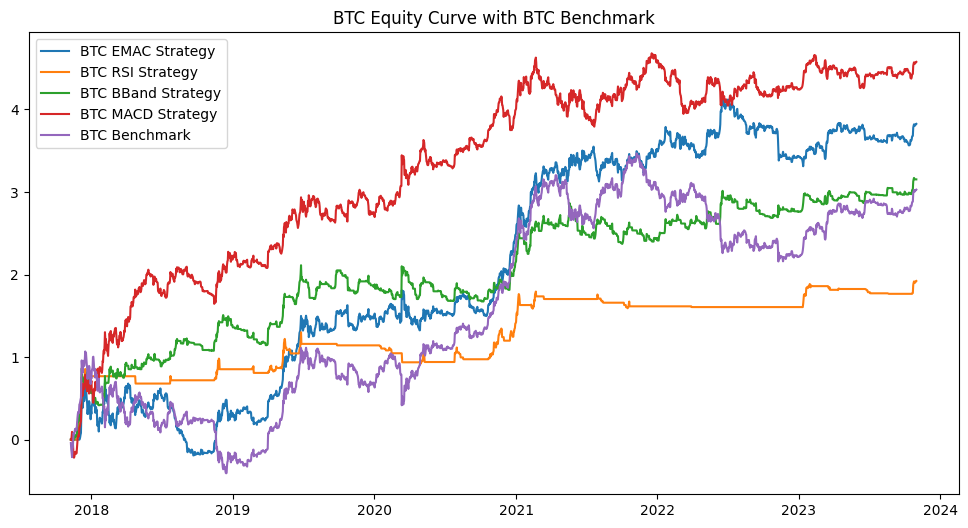

In [20]:
## Plot the equity curve for EMAC Straetgy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(btc_result[f'{btc_strategies[0]}_return_series'].cumsum(), label='BTC EMAC Strategy')
plt.plot(btc_result[f'{btc_strategies[1]}_return_series'].cumsum(), label='BTC RSI Strategy')
plt.plot(btc_result[f'{btc_strategies[2]}_return_series'].cumsum(), label='BTC BBand Strategy')
plt.plot(btc_result[f'{btc_strategies[3]}_return_series'].cumsum(), label='BTC MACD Strategy')
plt.plot(btc_df_full['ROC'].cumsum(), label='BTC Benchmark')
## add the legend, title
plt.legend()
plt.title('BTC Equity Curve with BTC Benchmark')
plt.show()

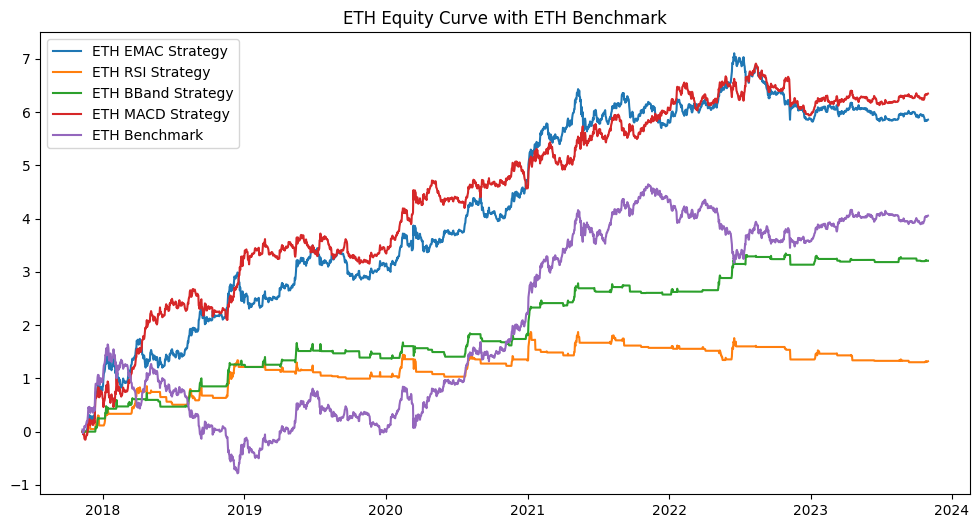

In [21]:
## plot the equity curve for ETH
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(eth_result[f'{eth_strategies[0]}_return_series'].cumsum(), label='ETH EMAC Strategy')
plt.plot(eth_result[f'{eth_strategies[1]}_return_series'].cumsum(), label='ETH RSI Strategy')
plt.plot(eth_result[f'{eth_strategies[2]}_return_series'].cumsum(), label='ETH BBand Strategy')
plt.plot(eth_result[f'{eth_strategies[3]}_return_series'].cumsum(), label='ETH MACD Strategy')
plt.plot(eth_df_full['ROC'].cumsum(), label='ETH Benchmark')

## add the legend, title
plt.legend()
plt.title('ETH Equity Curve with ETH Benchmark')
plt.show()

Thoughts and Conclusion:

1. We can see the EMAC Strategy and MACD Strategy on BTC and ETH can significantly bypass the buy and hold benchmark of the underlying, which shows the profitability of the two technical strategies (EMAC and MACD).

2. Inconsistency in terms of performance in the in-sample period, and the out-of-sample period. This is undesirable and may implies that the technical trading strategy might be applicable during in-sample period, but as the crypto market grow and more efficient, the performance of technical trading strategy is worsening.

3. The maximum drawdown from all strategies is unstaisfactory, ranging from 30% to 80%, this might due to the nature of the cryptocurrency market, where the market experience a extremely high volatility.

Suggestions:

1. Price data from cryptocurrency exchanges like Binance or Coinbase, should be used for more realistic simulation, instead of the data from yahoo finance

2. Price data starting from 2020-01-01 to 2023-12-31, could be used, since during this period, the market has gone through bull and bear, where we can better test the strategy performance in different market condition. Also, more frequent market data is also avaliable and should be used for backtesting, since more information could be given.

3. Extend the token universe to other altcoins

